# Exercise 1
Team: Lev Gromov, Mansur Daschaew, Marcel Morr

## 1 Exploring the Data

In [ ]:
# Load the data set
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

print(images.shape)
print(data.shape)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
(1797, 8, 8)
(1797, 64)


The size of the images is 64 (8 x 8) pixels which can be determined by looking at the `shape` attribute of `data`/`images`

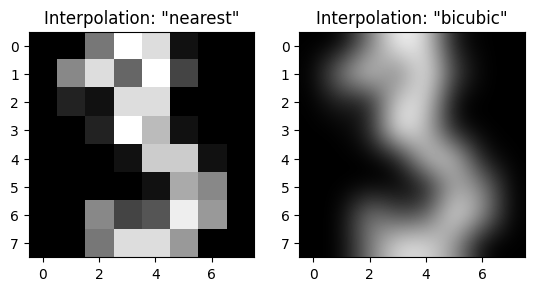

In [ ]:
# Show the image of a three using nearest and bicubic interpolation
import numpy as np
import matplotlib.pyplot as plt

img = images[3]

assert 2 == len(img.shape)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img, interpolation="nearest", cmap="gray")
ax2.imshow(img, interpolation="bicubic", cmap="gray")

ax1.set_title('Interpolation: "nearest"')
ax2.set_title('Interpolation: "bicubic"')

plt.show()


## 2.1 Feature construction

In [ ]:
from sklearn import model_selection

# Filter out everything except threes and nines from the data set
mask = (target == 3) | (target == 9)
X_all = data[mask]
y_all = target[mask]

# Relabel truth values: -1 indicates a three, +1 indicates a nine
y_all[y_all == 3] = -1
y_all[y_all == 9] = 1

# Split data set into a training set and a data set with a train/test ratio of 3/2
# test_size + 3/2 * test_size = 1 <=> test_size = 2/5 = 0.4
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_all, y_all,
                                                                    test_size=0.4, random_state=0)

print(X_all.shape)
print(X_train.shape, X_test.shape)
print(X_train.shape[0] / X_test.shape[0])

(363, 64)
(217, 64) (146, 64)
1.4863013698630136


### Experiment with feature reduction

Difference on average
 [ 0.          0.54402516  2.52847187  1.96447391  2.29712732  1.40056094
 -0.57598164 -0.01929288  0.          1.17142614 -0.73661397 -0.42792793
  1.35611083 -0.02677206 -0.20321265 -0.06646269  0.         -2.00016998
 -8.88228795 -2.46464389  3.22157063 -5.39622642 -2.16513683 -0.05660377
  0.         -1.73321435 -8.54011559 -3.21239164  0.79712732 -8.3672446
 -3.96523882  0.          0.         -0.08745538 -1.3754887   0.66250212
  6.79976203 -0.70108788 -3.03688594  0.          0.          0.39775625
  1.09459459  0.66947136  2.68043515  1.76976033  0.00985892  0.
  0.          0.38118307  1.42078871  1.5554139   2.88228795  2.41432942
  0.02252252 -0.07589665  0.          0.44747578  3.17848037  2.47671256
  0.30732619 -0.95784464 -1.28344382 -0.05702873]
Pixels with maximum absolute difference on average
 [18 26 29 36 21]
Maximum difference on average
 [-8.88228795 -8.54011559 -8.3672446   6.79976203 -5.39622642]
(2, 2)


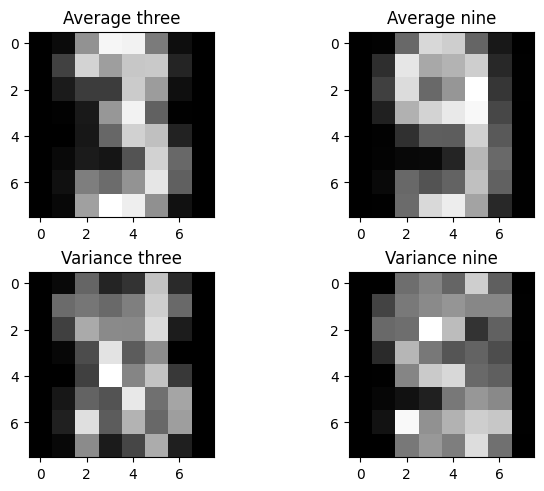

In [ ]:
# Experiment with different features
mean_three = np.mean(X_train[y_train == -1], axis=0) 
var_three = np.var(X_train[y_train == -1], axis=0)

mean_nine = np.mean(X_train[y_train == 1], axis=0)
var_nine = np.var(X_train[y_train == 1], axis=0)

diff = mean_three - mean_nine
print("Difference on average\n", diff)

best_pixels_amount = 5
max_abs_diff_pixels = np.flip(np.argsort(np.abs(diff)))[:best_pixels_amount]
max_diffs = diff[max_abs_diff_pixels]
print("Pixels with maximum absolute difference on average\n", max_abs_diff_pixels)
print("Maximum difference on average\n", max_diffs)

# plot mean and variance of threes and nines
fig, axs = plt.subplots(2,2, layout="constrained")
print(axs.shape)

for ax, img in zip(np.ravel(axs), [mean_three, mean_nine, var_three, var_nine]):
    ax.imshow(np.reshape(img, (8,8)), interpolation="nearest", cmap="gray")

for ax, title in zip(np.ravel(axs), ["Average three", "Average nine", "Variance three", "Variance nine"]):
     ax.set_title(title)

plt.show()

In [ ]:
# Define feature dimension reduction
def features2d(x):
    #return np.vstack((np.dot(x[:, max_diff_pixels], max_abs_difference), 
    #                  10 * x[:, 18] + 4* x[:, 36])).T
    return x[:, [26,18]]
    #return np.vstack((2 * x[:, 26] -0.5 * x[:, 35] + 0.3 * x[:, 19] + 0.1 * x[:, 46] + 0.1 * x[:, 61], x[:, 18])).T
    #return np.vstack((1.1 * x[:, 26] - 0.5 * x[:, 35] - 0.1 * x[:, 19], x[:, 18])).T
    #return np.vstack((x[:, 26] + 0.7 * x[:, 29], np.sum(x, axis=1))).T


## 2.2 Scatterplot

### Define a reusable plotting routine
Can easily switch out feature dimension reduction procedures and classifiers without having to rewrite code related to visualization

In [ ]:
from functools import partial
from numpy import linalg as LA
from scipy.stats import multivariate_normal

def plot_mean(ax, data_set, truth_labels):
        features = features2d(data_set)

        threes = features[truth_labels == -1]
        nines = features[truth_labels == 1]
        
        mean_threes = np.mean(threes, axis=0)
        mean_nines = np.mean(nines, axis=0)
        
        ax.scatter(*mean_threes, marker="v", c="green", s=100, label="mean 3", edgecolors="black")
        ax.scatter(*mean_nines, marker="^", c="red", s=100, label="mean 9", edgecolors="black")
        
        ax.legend()
    
def visualize(data_set, truth_labels, clf=None, resolution=200, mean=False, margin=np.array([0,0]),
             mu=None, covmat=None):
    features = features2d(data_set)
    # adjust fmin, fmax by margin to prevent markers from being cut off
    fmin, fmax = np.min(features, axis=0) - margin, np.max(features, axis=0) + margin

    threes = features[truth_labels == -1]
    nines = features[truth_labels == 1]
    
    if mean:
        mean_threes = np.mean(threes, axis=0)
        mean_nines = np.mean(nines, axis=0)
        
    if clf or mu is not None or covmat is not None:
        x = np.linspace(fmin[0], fmax[0]+1, resolution)
        y = np.linspace(fmin[1], fmax[1]+1, resolution)
        X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots()
    
    # plot data set
    ax.scatter(*threes.T, s=50, alpha=0.4, marker="v", label="3", edgecolors="black")
    ax.scatter(*nines.T, s=50, alpha=0.4, marker="^", label="9", edgecolors="black")
    # plot means
    if mean:
        ax.scatter(*mean_threes, marker="v", c="green", s=100, label="mean 3", edgecolors="black")
        ax.scatter(*mean_nines, marker="^", c="red", s=100, label="mean 9", edgecolors="black")
        
    # plot decision boundary
    if clf:
        all_features = np.vstack([X.ravel(), Y.ravel()]).T
        all_labels = clf(all_features)
        Z = np.reshape(all_labels, (x.shape[0], y.shape[0]))
        
        ax.contourf(X, Y, Z, colors=["blue", "orange"], levels=1, alpha=0.3)
    
    # plot gaussian
    if mu is not None or covmat is not None:
        normal_dist_threes = multivariate_normal(mu[0, :], covmat) 
        normal_dist_nines =  multivariate_normal(mu[1, :], covmat)

        w, v = LA.eig(covmat)

        ax.contour(X, Y, normal_dist_threes.pdf(np.dstack((X,Y))), levels=3, alpha=0.8, colors="blue")
        ax.contour(X, Y, normal_dist_nines.pdf(np.dstack((X,Y))), levels=3, alpha=0.8, colors="orange")

        for mean in mu:
            for eig_val, eig_vec in zip(np.sqrt(w), v):
                ax.annotate("", mean + eig_val * eig_vec, mean,
                            arrowprops=dict(facecolor="black", width=0.1, headwidth=4, headlength=5))
        
    ax.set_xlabel(r"$\tilde{f}_1 = f_{26}$")
    ax.set_ylabel(r"$\tilde{f}_2 = f_{18}$")
    ax.legend()
    
    return fig, ax

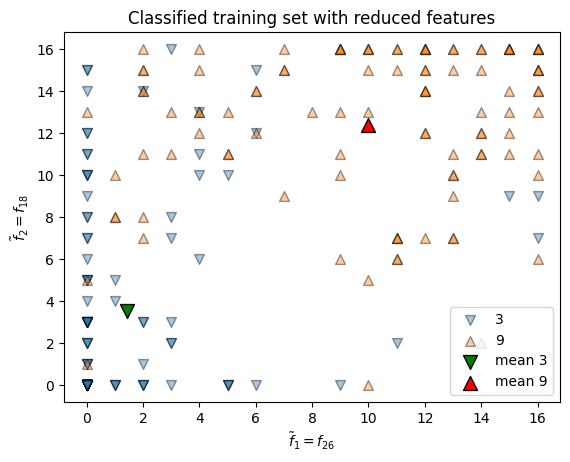

In [ ]:
fig, ax = visualize(X_train, y_train, mean=True)
ax.set_title("Classified training set with reduced features")
plt.show()

## 2.3 Decision rule

In [ ]:
from numpy import linalg as LA

def nearest_mean(training_features, training_labels, test_features):
    mean_threes = np.mean(training_features[training_labels == -1], axis=0)
    mean_nines = np.mean(training_features[training_labels == 1], axis=0)

    dist_three = LA.norm(test_features - mean_threes, axis=1)
    dist_nine = LA.norm(test_features - mean_nines, axis=1)

    return -1 + 2 * (dist_nine < dist_three)

In [ ]:
def error_rate(test_features, test_labels, clf):
    false_classifications_test = clf(test_features) != test_labels
    
    return np.mean(false_classifications_test, axis=0)    

In [ ]:
print("2D-features")
nm = partial(nearest_mean, features2d(X_train), y_train)
print("Training error:", error_rate(features2d(X_train), y_train, nm))
print("Test error:", error_rate(features2d(X_test), y_test, nm))
print("Full 64D-features")
nm_full = partial(nearest_mean, X_train, y_train)
print("Training error:", error_rate(X_train, y_train, nm_full))
print("Test error:", error_rate(X_test, y_test, nm_full))

2D-features
Training error: 0.11059907834101383
Test error: 0.0821917808219178
Full 64D-features
Training error: 0.02304147465437788
Test error: 0.0273972602739726


## 2.4 Visualize the decision regions

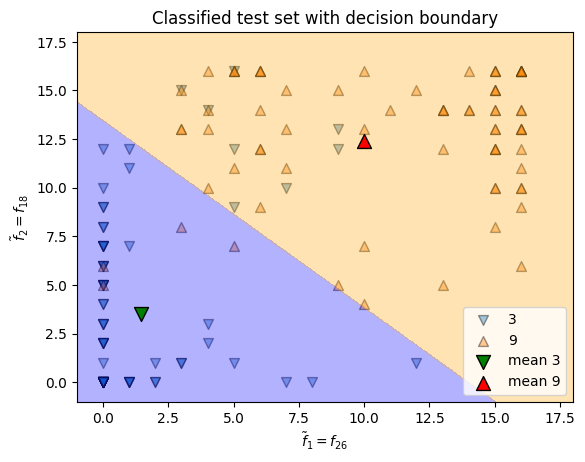

In [ ]:
nm = partial(nearest_mean, features2d(X_train), y_train)
fig, ax = visualize(X_test, y_test, margin=np.array([1,1]), clf=nm, resolution=1000)
plot_mean(ax, X_train, y_train)
ax.set_title("Classified test set with decision boundary")
plt.show()

## 3.1 Implement LDA training

In [ ]:
def fit_lda(training_features, training_labels):
    threes = training_features[training_labels == -1]
    nines = training_features[training_labels == 1]
    
    mu = np.vstack((np.mean(threes, axis=0), np.mean(nines, axis=0)))
    
    covmat = np.mean(np.concatenate([np.einsum("if,ig->ifg", threes - mu[0, :], threes - mu[0, :]),
                            np.einsum("if,ig->ifg", nines - mu[1, :], nines - mu[1, :])], axis=0),
            axis=0)
    
    p = np.array([threes.shape[0] / training_features.shape[0],
                  nines.shape[0] / training_features.shape[0]])
    
    return mu, covmat, p

## 3.2 Implement LDA prediction

In [ ]:
def predict_lda(mu, covmat, p, test_features):
    inv_covmat = LA.inv(covmat) if LA.det(covmat) != 0 else LA.pinv(covmat)
    beta = inv_covmat @ (mu[1] - mu[0]).T
    b = -0.5 * (mu[1] - mu[0]) @ beta + np.log(p[1]/p[0])
    return -1 + 2 * ((test_features @ beta + b) > 0)

In [ ]:
mu, covmat, p = fit_lda(features2d(X_train), y_train)
lda = partial(predict_lda, *fit_lda(features2d(X_train), y_train))
print("Training error:", error_rate(features2d(X_train), y_train, lda))
print("Test error:", error_rate(features2d(X_test), y_test, lda))

Training error: 0.1382488479262673
Test error: 0.10273972602739725


## 3.3 Visualization

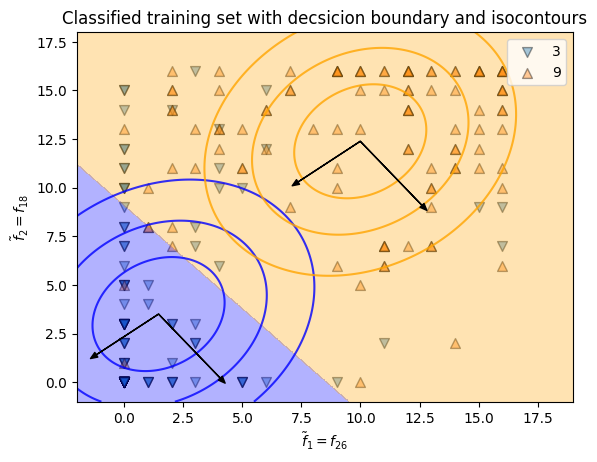

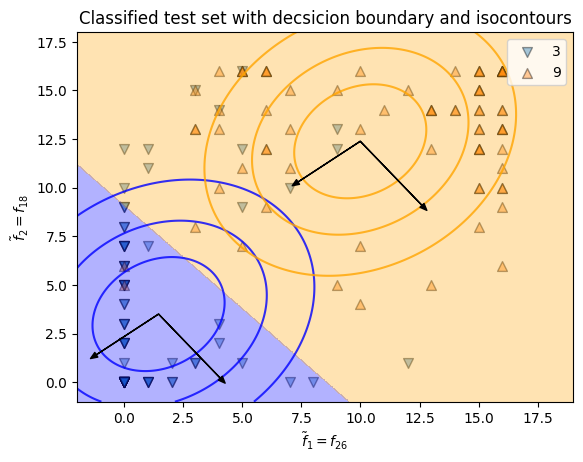

In [ ]:
mu, covmat, p = fit_lda(features2d(X_train), y_train)
lda = partial(predict_lda, *fit_lda(features2d(X_train), y_train))
fig, ax = visualize(X_train, y_train, clf=lda, mu=mu, covmat=covmat, margin=[2,1], resolution=1000)
ax.set_title("Classified training set with decsicion boundary and isocontours")
fig, ax = visualize(X_test, y_test, clf=lda, mu=mu, covmat=covmat, margin=[2,1], resolution=1000)
ax.set_title("Classified test set with decsicion boundary and isocontours")
plt.show()

The LDA classifier only performs okay-ish because the feature reduction procedure doesn't deliver nicely clustered data.

## 3.4 Quantitative performance evaluation

In [ ]:
from sklearn.model_selection import KFold

def error_cross(X_all, y_all, n_splits=10):
    kf = KFold(n_splits=10)
    errors = {"train" : [], "test" : []}

    for train_index, test_index in kf.split(X_all, y_all):
        training_features, training_labels = X_all[train_index, :], y_all[train_index]
        test_features, test_labels = X_all[test_index, :], y_all[test_index]

        mu, covmat, p = fit_lda(training_features, training_labels)
        lda = partial(predict_lda, mu, covmat, p)

        errors["train"].append(error_rate(training_features, training_labels, lda))
        errors["test"].append(error_rate(test_features, test_labels, lda))
    return errors

errors = error_cross(X_all, y_all)
print("Training Error: mean={0}, std={1}".format(np.mean(errors["train"]), np.std(errors["train"])))
print("Test Error: mean={0}, std={1}".format(np.mean(errors["test"]), np.std(errors["test"])))

Training Error: mean=0.021123431080092306, std=0.014131699630924326
Test Error: mean=0.05495495495495495, std=0.05488989239992243


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate

clf = LinearDiscriminantAnalysis()
scores = cross_validate(clf, X_all, y_all, cv=10, scoring="accuracy", return_train_score=True)

train_errors = 1 - scores["train_score"]
test_errors = 1 - scores["test_score"]

print("Training Error: mean={0}, std={1}".format(np.mean(train_errors), np.std(train_errors)))
print("Test Error: mean={0}, std={1}".format(np.mean(test_errors), np.std(test_errors)))

Training Error: mean=0.003672538976754669, std=0.0012218412390732475
Test Error: mean=0.02207207207207207, std=0.027187544685194236


## Extra: generating images

In [ ]:
mu, covmat, p = fit_lda(X_all, y_all)
rng = np.random.default_rng(seed=0)
def gen_three(): return rng.multivariate_normal(mu[0, :], covmat)
def gen_nine(): return rng.multivariate_normal(mu[1, :], covmat)

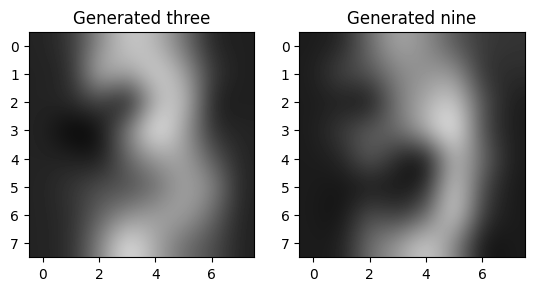

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)

three = np.reshape(gen_three(), (8,8))
nine = np.reshape(gen_nine(), (8,8))

ax1.imshow(three, interpolation="bicubic", cmap="gray")
ax2.imshow(nine, interpolation="bicubic", cmap="gray")

ax1.set_title("Generated three")
ax2.set_title("Generated nine")

plt.show()

# 4 SVM

## 4.1 Implement SVM training

In [ ]:
def fit_svm(training_features, training_labels, lmbda, steps):    
    def loss(beta, b, penalized):
        return (0.5 * np.dot(beta, beta)
                + lmbda/N * np.sum(1 - training_labels[penalized] * (training_features[penalized] @ beta + b)))
    
    def get_penalties(beta, b):
        return (training_labels * (training_features @ beta + b)) < 1
        
    beta = np.random.default_rng().normal(size=training_features.shape[1])
    b = 0
    tau = 0.001
    N = training_features.shape[0]

    history = {"beta" : [beta.copy()], "b" : [b], "loss" : [], "grad" : []}

    for i in range(steps):
        penalized = get_penalties(beta, b)
        l = loss(beta, b, penalized) 

        grad_beta = beta + lmbda/N* np.sum(-training_labels[penalized, np.newaxis] * training_features[penalized], axis=0)
        grad_b = lmbda/N * np.sum(-training_labels[penalized])
        
        beta -= tau * grad_beta
        b -= tau * grad_b
        
        history["beta"].append(beta.copy())
        history["b"].append(b.copy())
        history["loss"].append(l)
        history["grad"].append(np.append(grad_beta, grad_b))
        
    history["loss"].append(loss(beta, b, get_penalties(beta, b)))
    
    return beta, b, history

## 4.2 Implement SVM prediciton and tuning

In [ ]:
def predict_svm(beta, b, test_features):
    return -1 + 2 * ((test_features @ beta + b) > 0)

In [ ]:
from sklearn.model_selection import KFold

candidates = np.array([1e-2, 1e-1, 1e0, 1e1, 1e2])

def tune_hyperparameter(X_all, y_all,  candidates, n_splits=10):
    mean = {"train" : [], "test" : []}
    var = {"train" : [], "test" : []}
    for param in candidates:
        kf = KFold(n_splits=5)
        errors = {"train" : [], "test" : []}

        for train_index, test_index in kf.split(X_all, y_all):
            training_features, training_labels = X_all[train_index, :], y_all[train_index]
            test_features, test_labels = X_all[test_index, :], y_all[test_index]

            beta, b, history = fit_svm(training_features, training_labels, param, 5000)
            svm = partial(predict_svm, beta, b)

            errors["train"].append(error_rate(training_features, training_labels, svm))
            errors["test"].append(error_rate(test_features, test_labels, svm))
        
        mean["train"].append(np.mean(errors["train"]))
        mean["test"].append(np.mean(errors["test"]))
        var["train"].append(np.var(errors["train"]))
        var["test"].append(np.var(errors["test"]))
        
    return mean, var

mean, var = tune_hyperparameter(features2d(X_train), y_train, candidates)
best_train_idx = np.argsort(mean["train"]) 
best_test_idx = np.argsort(mean["test"])

print("Best training lambdas:", candidates[best_train_idx])
print("Best training errors:", np.sort(mean["train"]))
print("Best test lambdas:", candidates[best_test_idx])
print("Best test errors:", np.sort(mean["test"]))

Best training lambdas: [1.e+00 1.e+01 1.e+02 1.e-01 1.e-02]
Best training errors: [0.10367417 0.10944123 0.11403893 0.25695303 0.31798552]
Best test lambdas: [1.e+00 1.e+01 1.e+02 1.e-01 1.e-02]
Best test errors: [0.10591966 0.10602537 0.10602537 0.2538055  0.31818182]


In [ ]:
beta, b, history = fit_svm(features2d(X_train), y_train, lmbda=1, steps=10000)
svm = partial(predict_svm, beta, b)
print("Training error:", error_rate(features2d(X_train), y_train, svm))
print("Test error:", error_rate(features2d(X_test), y_test, svm))

Training error: 0.10599078341013825
Test error: 0.0821917808219178


## 4.3 Visualization

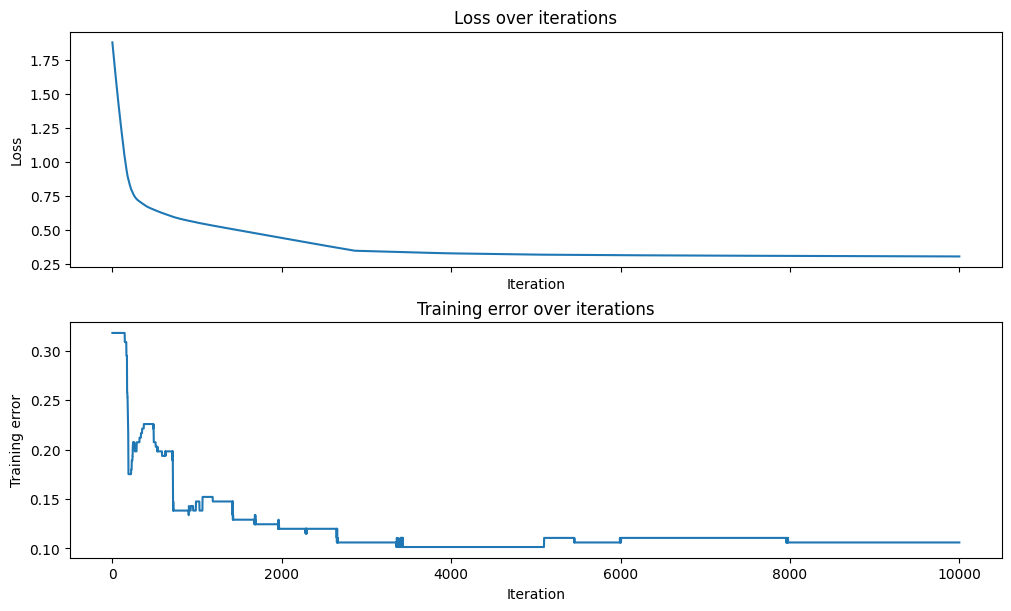

In [ ]:
beta, b, history = fit_svm(features2d(X_train), y_train, lmbda=1, steps=10000)
svm = partial(predict_svm, np.array(history["beta"]).T, np.array(history["b"]).T)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), sharex=True, layout="constrained")

ax1.plot(history["loss"])
ax2.plot(error_rate(features2d(X_train), y_train[:, np.newaxis], svm))

ax1.set_title("Loss over iterations")
ax2.set_title("Training error over iterations")

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Training error")

plt.show()

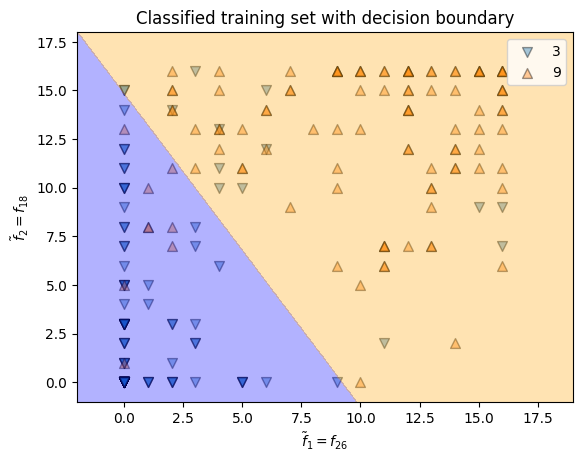

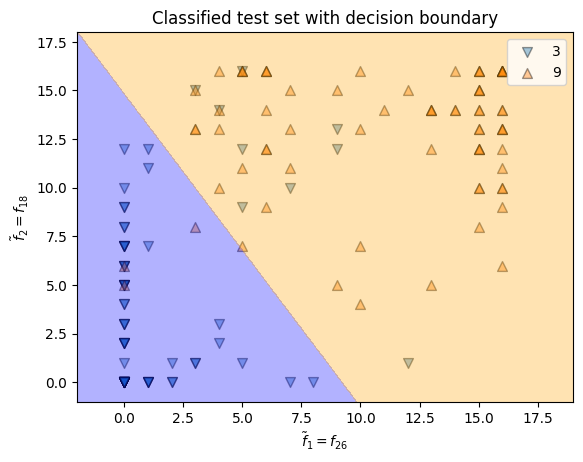

In [ ]:
beta, b, history = fit_svm(features2d(X_train), y_train, lmbda=1, steps=10000)
svm = partial(predict_svm, beta, b)
# Training set
fig, ax = visualize(X_train, y_train, clf=svm, margin=[2,1], resolution=1000)
ax.set_title("Classified training set with decision boundary")
# Test set
fig, ax = visualize(X_test, y_test, clf=svm, margin=[2,1], resolution=1000)
ax.set_title("Classified test set with decision boundary")

plt.show()

## 4.4 Quantitative performance evaluation

### Our implementation

In [ ]:
beta, b, history = fit_svm(features2d(X_train), y_train, lmbda=1, steps=10000)
svm = partial(predict_svm, beta, b)
print("2D-features")
print("Training error:", error_rate(features2d(X_train), y_train, svm))
print("Test error:", error_rate(features2d(X_test), y_test, svm))
beta, b, history = fit_svm(X_train, y_train, lmbda=100, steps=10000)
svm = partial(predict_svm, beta, b)
print("Full 64D-features")
print("Training error:", error_rate(X_train, y_train, svm))
print("Test error:", error_rate(X_test, y_test, svm))

2D-features
Training error: 0.10599078341013825
Test error: 0.0821917808219178
Full 64D-features
Training error: 0.0
Test error: 0.0


### Scikit-learn

In [ ]:
from sklearn import svm
print("2D-features")
clf = svm.LinearSVC(max_iter=10000)
clf.fit(features2d(X_train), y_train)
print("Training error:", error_rate(features2d(X_train), y_train, clf.predict))
print("Test error:", error_rate(features2d(X_test), y_test, clf.predict))
print("Full 64D-features:")
clf = svm.LinearSVC(max_iter=10000)
clf.fit(X_train, y_train)
print("Training error:", error_rate(X_train, y_train, clf.predict))
print("Test error:", error_rate(X_test, y_test, clf.predict))



2D-features
Training error: 0.11059907834101383
Test error: 0.08904109589041095
Full 64D-features:
Training error: 0.0
Test error: 0.0


## Classifier comparison
Full feature space:
The SVM classifer performs the best by far achieving a training and test error of 0. The LDA and NM classifiers perform similarly with an error rate of approximately 0.02.

Reduced feature space:
With the current implementation of the feature reduction procedure, i.e. choose the two pixels with the largest absolute difference on average, all classifiers perform about the same with an error rate of approximately 0.1.